In [1]:
%matplotlib inline
%load_ext autoreload
%config InlineBackend.figure_format = 'retina' # high res plotting
import numpy as np
import scipy
import matplotlib.pyplot as plt
import IPython.display as ipd
import sys
# import os 
# import h5py

In [2]:
# Import Seaborn

import seaborn as sns
# sns.set_style('whitegrid')

In [3]:
import matplotlib
# plot settings
# font = {'family' : 'Bitstream Vera Sans',
#         'weight' : 'regular',
#         'size'   : 13}
font = {'weight' : 'regular',
        'size'   : 13}
figure = {'figsize' : (20,8)}

matplotlib.rc('font', **font)
matplotlib.rc('figure', **figure)

In [4]:
%autoreload 2
# import BirdSongToolbox.GetBirdData as gbd
# import BirdSongToolbox.file_utility_functions as fuf
# import BirdSongToolbox.Epoch_Analysis_Tools as bep
# import BirdSongToolbox as tb
from BirdSongToolbox.file_utility_functions import _load_pckl_data , _load_numpy_data, _load_json_data
import BirdSongToolbox.free_epoch_tools as fet
import BirdSongToolbox.preprocess as pp

from BirdSongToolbox.import_data import ImportData
from BirdSongToolbox.context_hand_labeling import ContextLabels
from BirdSongToolbox.context_hand_labeling import label_focus_context, first_context_func, last_context_func, mid_context_func
from BirdSongToolbox.behave.behave_utils import event_array_maker_chunk, get_events_rasters, repeat_events


In [5]:
#file structure for /src
package_folder = '/home/debrown/Songbird-LFP-Paper/'
sys.path.append(package_folder)


In [6]:
%autoreload 2
import src.analysis.hilbert_based_pipeline as hbp


# Get the Data

In [7]:
# Select bird_id and session
bird_id = 'z007'
session =  'day-2016-09-09'
# 'day-2016-09-11'

In [8]:
zdata = ImportData(bird_id=bird_id, session=session)

# Get the Handlables

In [9]:
# # load Handlabels
# chunk_labels = _load_pckl_data(data_name= "chunk_handlabels_Song", bird_id=bird_id, session=session, 
#                                source="/home/debrown/Chunk_Data_Temp")

# Reshape Handlabels into Useful Format
chunk_labels_list, chunk_onsets_list = fet.get_chunk_handlabels(handlabels_list=zdata.song_handlabels)


# Get the Start Times of the Events of Interest

In [10]:
label_instructions=[1] # Get the Start of Every First Syllable

times_of_interest = fet.label_extractor(all_labels=chunk_labels_list, 
                                        starts =  chunk_onsets_list[0],
                                        label_instructions = label_instructions)


In [11]:
#a Create instance of the Context Labels Class

bout_states = {8:'not', 'I':'not', 'C':'not', 1:'bout',2:'bout',3:'bout',4:'bout',5:'bout',6:'bout',7:'bout', 
               "BUFFER":"not", "X":"not"}
bout_transitions = {'not':1,'bout':8}
bout_syll_length = 5
testclass = ContextLabels(bout_states, bout_transitions, full_bout_length = bout_syll_length)

In [12]:
# Get the Context Array for the Day's Data

test_context = testclass.get_all_context_index_arrays(chunk_labels_list)

In [13]:
# Get the First Syllable of Every Bout
first_syll = label_focus_context(focus=1, 
                                      labels=chunk_labels_list, 
                                      starts= chunk_onsets_list[0], 
                                      contexts= test_context, 
                                      context_func=first_context_func)
last_syll = label_focus_context(focus=1, 
                                      labels=chunk_labels_list, 
                                      starts= chunk_onsets_list[0], 
                                      contexts= test_context, 
                                      context_func=last_context_func)

---
# Plot all of the Chunks for one day

(0, 50)

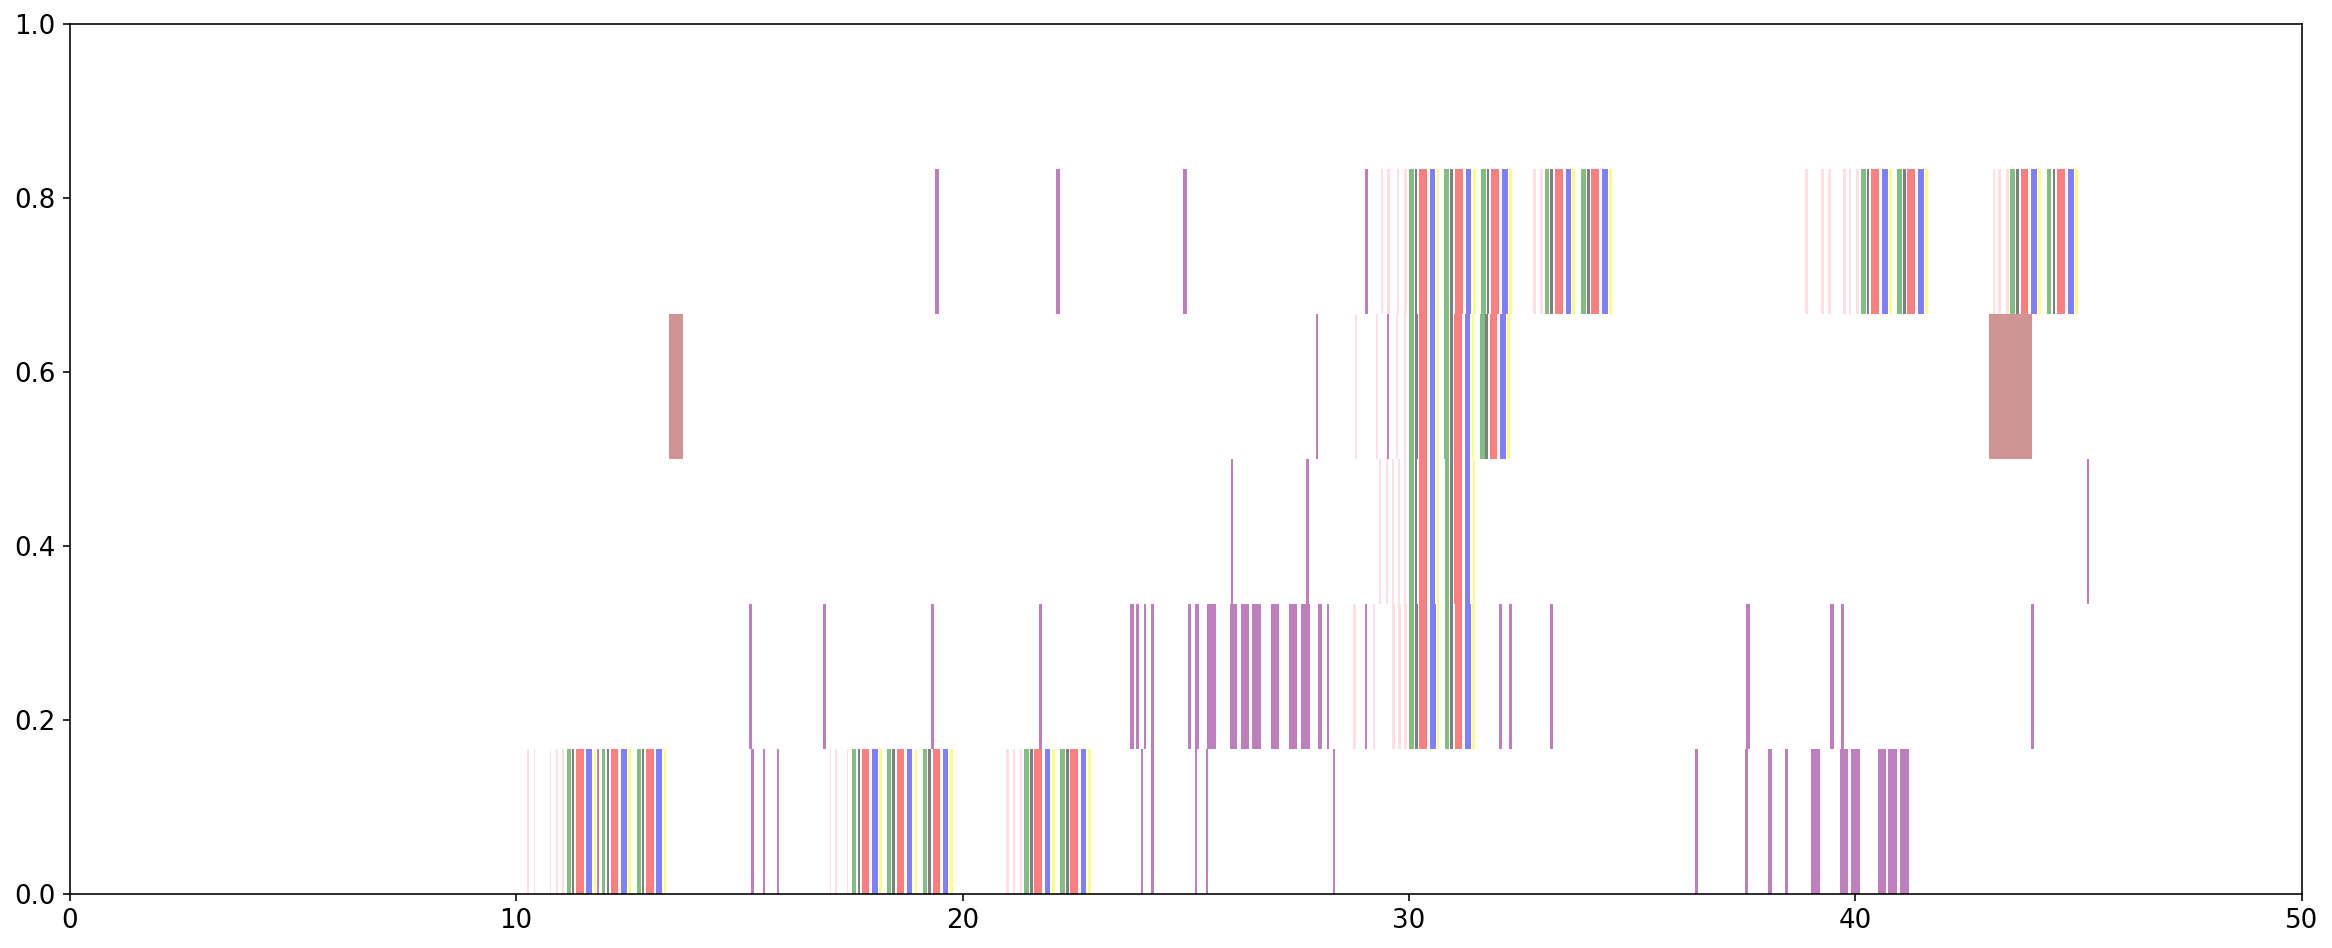

In [14]:
# Determine the vertical spacing of the Chunks
num_chunk = len(chunk_labels_list)

steps = np.arange(0,1, 1/(num_chunk+1))

# Plot the Syllable Level Behavior

colors= {1:'green',2:'black',3:'red', 4:'blue' ,5:'yellow', 6:'purple', 7:'white', 8:'white','I':'pink', 
         'C':'purple', 'BUFFER': 'white', 'X': 'brown'}

for index, (chunk_labels2, chunk_starts2, chunk_ends2) in enumerate(zip(chunk_labels_list, chunk_onsets_list[0], chunk_onsets_list[1])):
    for label, start, end in zip(chunk_labels2, chunk_starts2, chunk_ends2):
        color = colors[label]
        corrected_start = (start)/30000  # Correct for the Relative Start Time and resolution
        corrected_end = (end)/30000 # Correct for the Relative Start Time and resolution
        plt.axvspan(xmin=corrected_start, xmax=corrected_end, ymin=steps[index], ymax=steps[index +1], facecolor=color, alpha=0.5)
        
plt.xlim(0, 50)  # Arbitrary

# Select the Times of the Different Levels
    [] Full Days Recording
    [] Chunk
    [] 1 Bout

In [15]:
# Get the Times for this Specific Chunk
selected_chunk = 4

chunk_starts = chunk_onsets_list[0][selected_chunk]  # Start Times within the Selected Chunk
chunk_ends = chunk_onsets_list[1][selected_chunk]  # Ends Times within the Selected Chunk
chunk_labels = chunk_labels_list[selected_chunk]  # Labels for events in the Selected Chunk

In [16]:
# Determine the Chunk Level Timing
chunk_before_sample = chunk_ends[0]  # The End of the Buffer
chunk_end_sample = chunk_starts[-1] - chunk_ends[0]  # The Start of the end Buffer

# Special Adjustment
before_adjustment = 15 * 30000
after_adjustment = 5 * 30000
chunk_before_sample = chunk_before_sample + before_adjustment
chunk_end_sample = chunk_end_sample - after_adjustment


# chunk_end_x = (chunk_starts[-1] - chunk_ends[0])/30000

print(f'Full Duration is {(chunk_end_sample - chunk_before_sample)/30000} seconds')

Full Duration is 24.297333333333334 seconds


In [17]:
# Normalize the Audio Data
chunk1_audio = zdata.song_audio[selected_chunk]/max(zdata.song_audio[selected_chunk])

# Get the Audio Data
chunk1_audio_spect = zdata.song_audio[selected_chunk]

# # Get Chunk for Spectrogram
# chunk1_audio_spect2 = zdata.song_audio[selected_chunk][bout_start_sample:bout_end_sample]


In [18]:
# Determine the Chunk Level Timing

buffer_before = 30000
buffer_after = 30000 
before_sample = first_syll[4][0] - buffer_before
afer_sample = last_syll[4][2] + buffer_after

(afer_sample - before_sample)/ 30000


12.937733333333334

In [19]:
def spectrogram(x, s_f, cut_off=1, window=None, n_perseg=None, n_overlap=None, sigma=0.3, nfft=None):
    if window is None:
        window = scipy.signal.gaussian(n_perseg, sigma)

    f, t, s = scipy.signal.spectrogram(np.transpose(x), fs=s_f, window=window,
                                       nperseg=n_perseg,
                                       noverlap=n_overlap,
                                       nfft=nfft,
                                       detrend='constant', return_onesided=True,
                                       scaling='density', axis=-1, mode='psd')

    # Apply Threshold to the Spectrogram
    s[s < cut_off] = cut_off

    return f, t, s

# From Zeke
def normalize(u, axis=0):
    # normalize to (0-1) along axis
    # (axis=0 to normalize every col to its max value, axis=0 to normalize every row to its max value)
    u_max = np.repeat(np.amax(u, axis=axis, keepdims=True), u.shape[axis], axis=axis)
    # print(u_max.shape)
    u_min = np.repeat(np.amin(u, axis=axis, keepdims=True), u.shape[axis], axis=axis)

    u_range = u_max - u_min
    u_range[u_range==0] = 1 # prevent nans, if range is zero set the value to 1.
    return (u - u_min)/u_range

# Adapted From Zeke
def my_spectrogram(Audio, s_f=30000, step_s=.001, window=None, n_perseg=192, f_cut=1, nfft=None, sigma=40):

    n_overlap = n_perseg - int(s_f * step_s)

    f, t, s = spectrogram(Audio, s_f=s_f, cut_off=f_cut, window=window, n_perseg=n_perseg, n_overlap=n_overlap,
                          sigma=sigma, nfft=nfft)

    s_normalized = normalize(np.log(s), axis=-1)
    return f, t, s_normalized

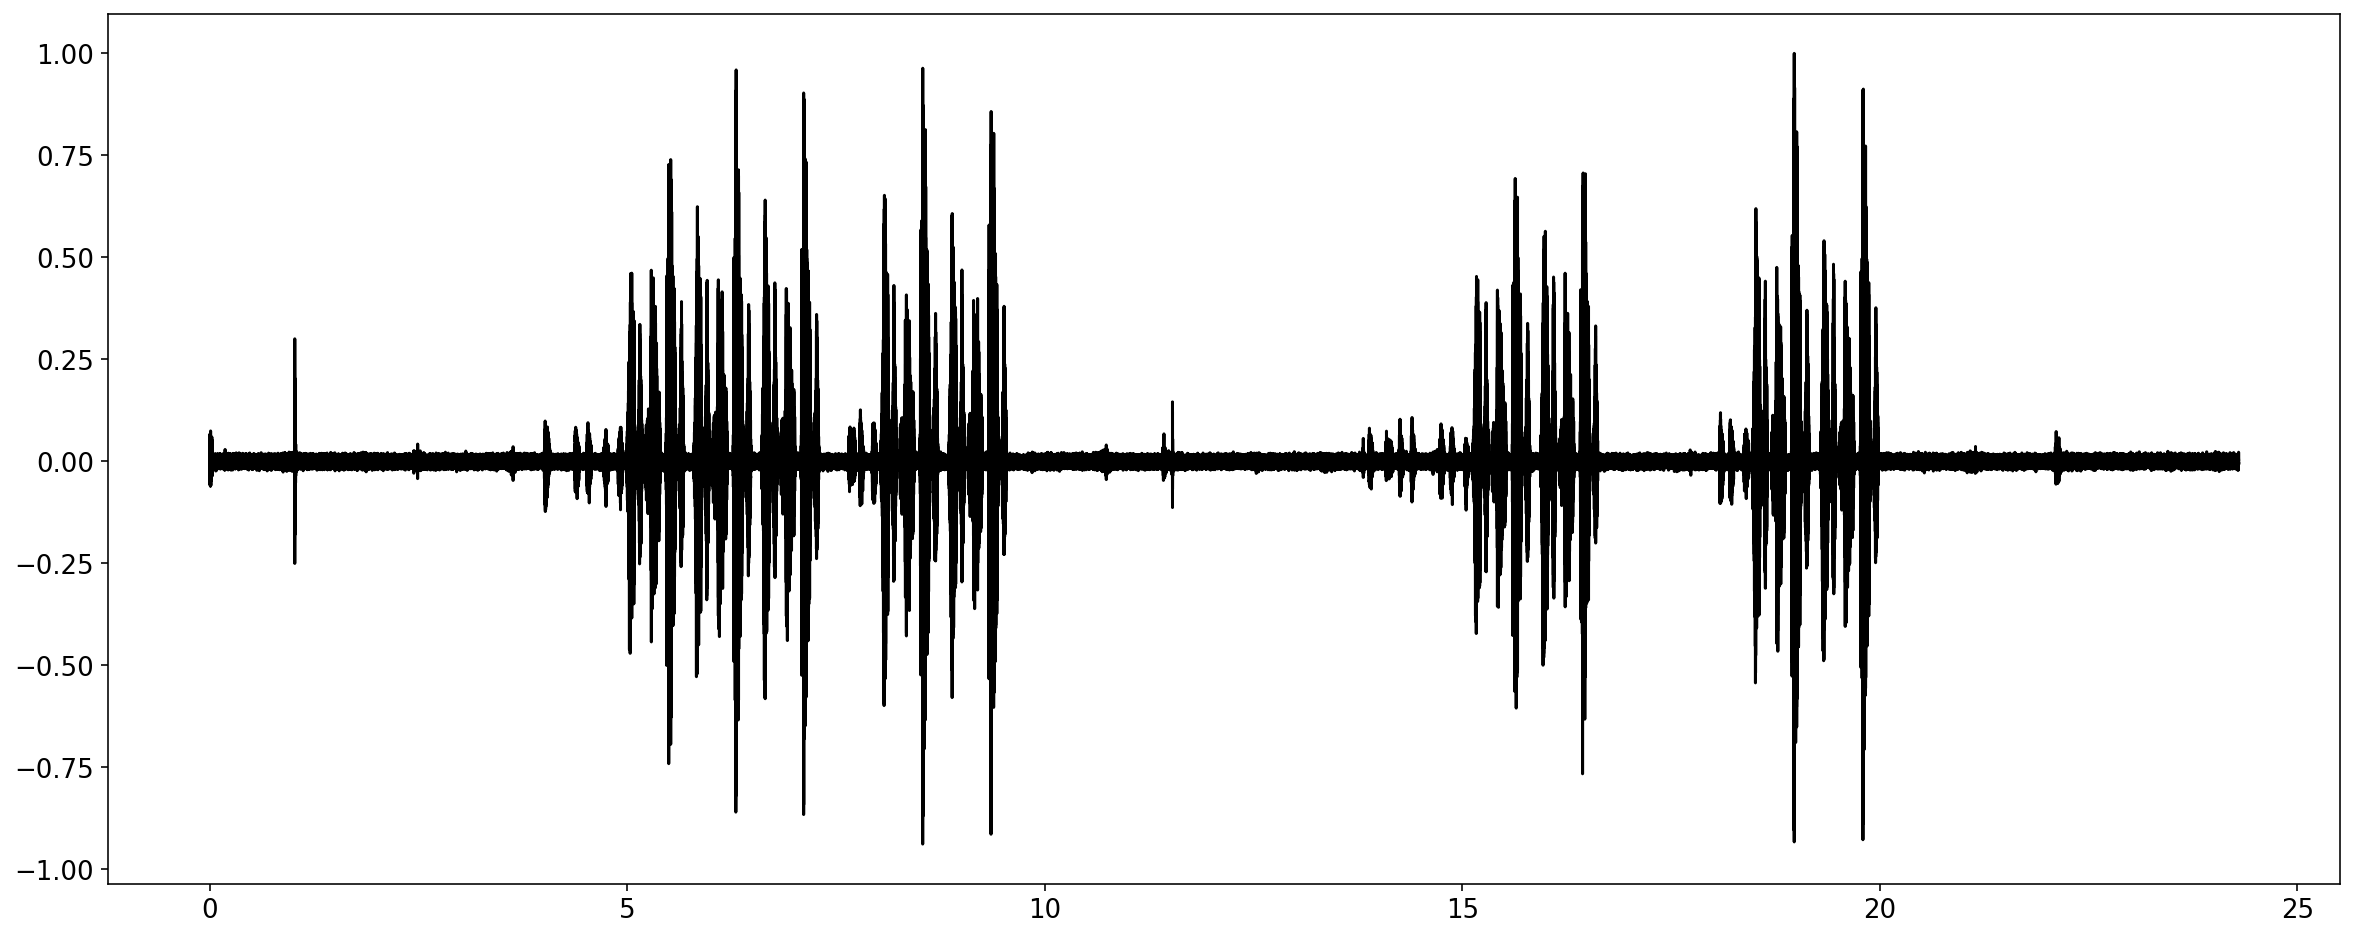

In [20]:
# Plot The Pressure Waveform
chunk_level_audio = chunk1_audio[chunk_before_sample:chunk_end_sample]  # Clip out the Chunk level
chunk_level_length = len(chunk_level_audio)/30000  # Convert x to seconds
chunk_level_xaxis = np.arange(0, chunk_level_length, 1/30000)

plt.plot(chunk_level_xaxis, chunk_level_audio, color = 'black')
plt.show()

In [21]:
# Plot the Spectrogram 
chunk_level_spect = chunk1_audio_spect[chunk_before_sample:chunk_end_sample]  # Get the Signal from time shown above

f1, t1, s1 = my_spectrogram(chunk_level_spect, f_cut=.5, nfft=200)

## Make a Plot of the Bout Level Behavior


In [22]:
# This could probably be used for other things too

def get_bout_end(contexts, labels):
    """ Get the Label or time of the end of the motif"""
    all_ends = []
    for context, chunk in zip(contexts, labels):
        chunk_ends = []
        for index, last_context in enumerate(context[:-1,2]):
            if last_context == 1 and context[index+1, 2] ==0:
                chunk_ends.append(chunk[index])
        all_ends.append(chunk_ends)
    return all_ends

In [23]:
bout_ends = get_bout_end(test_context, chunk_onsets_list[1])


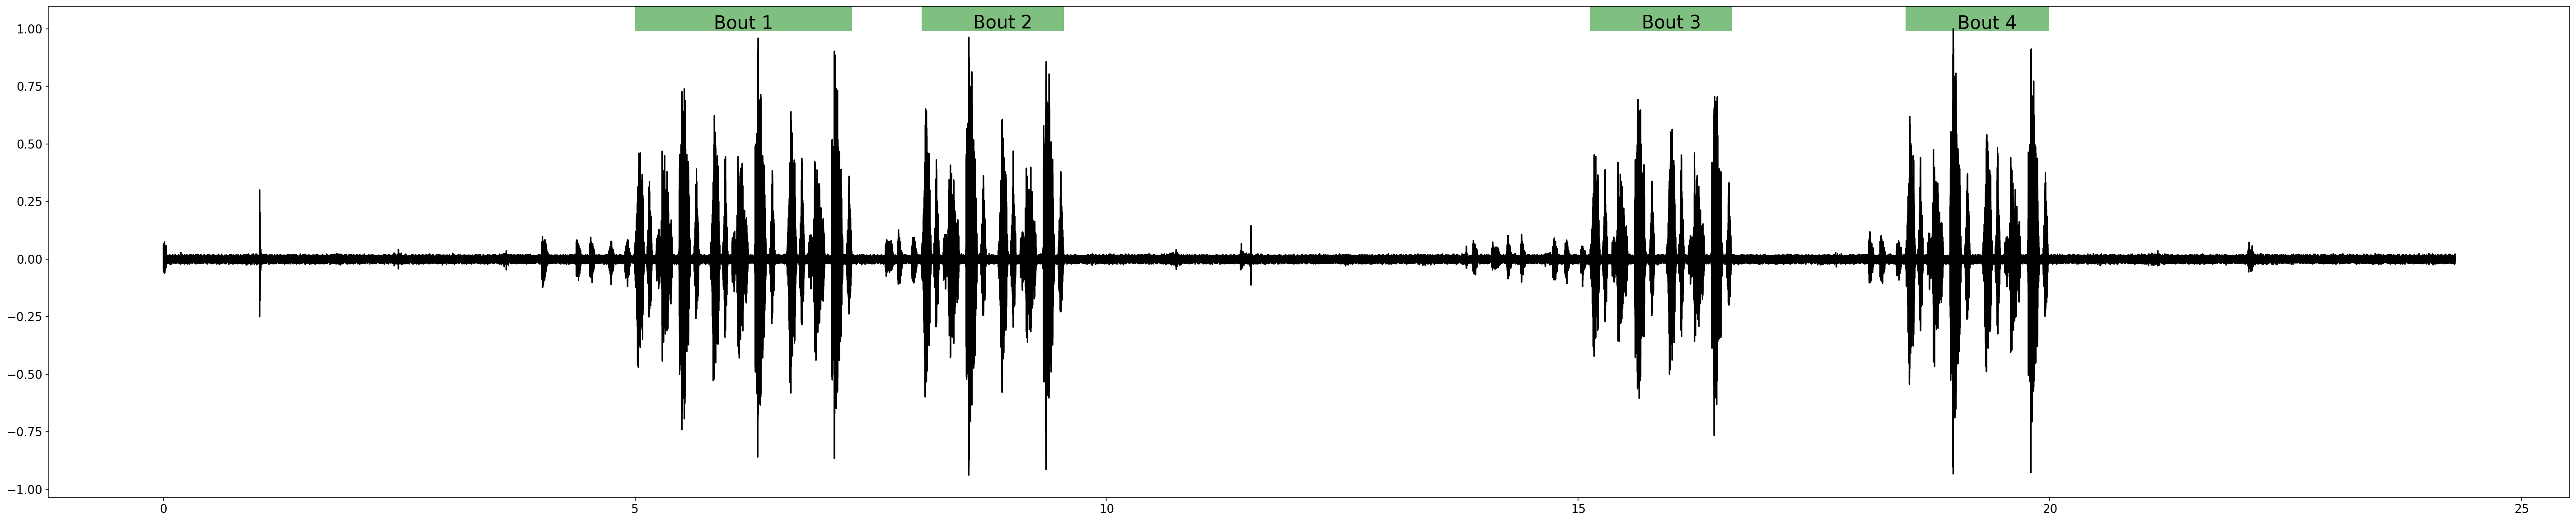

In [24]:
fig = plt.figure(figsize=(50,10))

bout_counter = 0

for start, end in zip(first_syll[4], bout_ends[4]):
    color = 'green'
    corrected_start = (start-chunk_before_sample)/30000  # Correct for the Relative Start Time and resolution
    corrected_end = (end-chunk_before_sample)/30000 # Correct for the Relative Start Time and resolution
    plt.axvspan(xmin=corrected_start, xmax=corrected_end, ymin=.95,ymax=1, facecolor=color, alpha=0.5)
    
    # Add Annotations for the different Levels
    if corrected_start > 0 :
        bout_counter += 1
        bout_dur = (corrected_end - corrected_start)
        middle_point2 = ((corrected_end - corrected_start)/2.75) + corrected_start
        plt.annotate(f'Bout {bout_counter}', xy=(middle_point2, 1), xycoords='data', fontsize=20)
        
    
plt.plot(chunk_level_xaxis, chunk_level_audio, color = 'black')

In [25]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=18)

# from src.utils.paths import FIGURES_DIR


In [26]:
sns.set_context("paper")

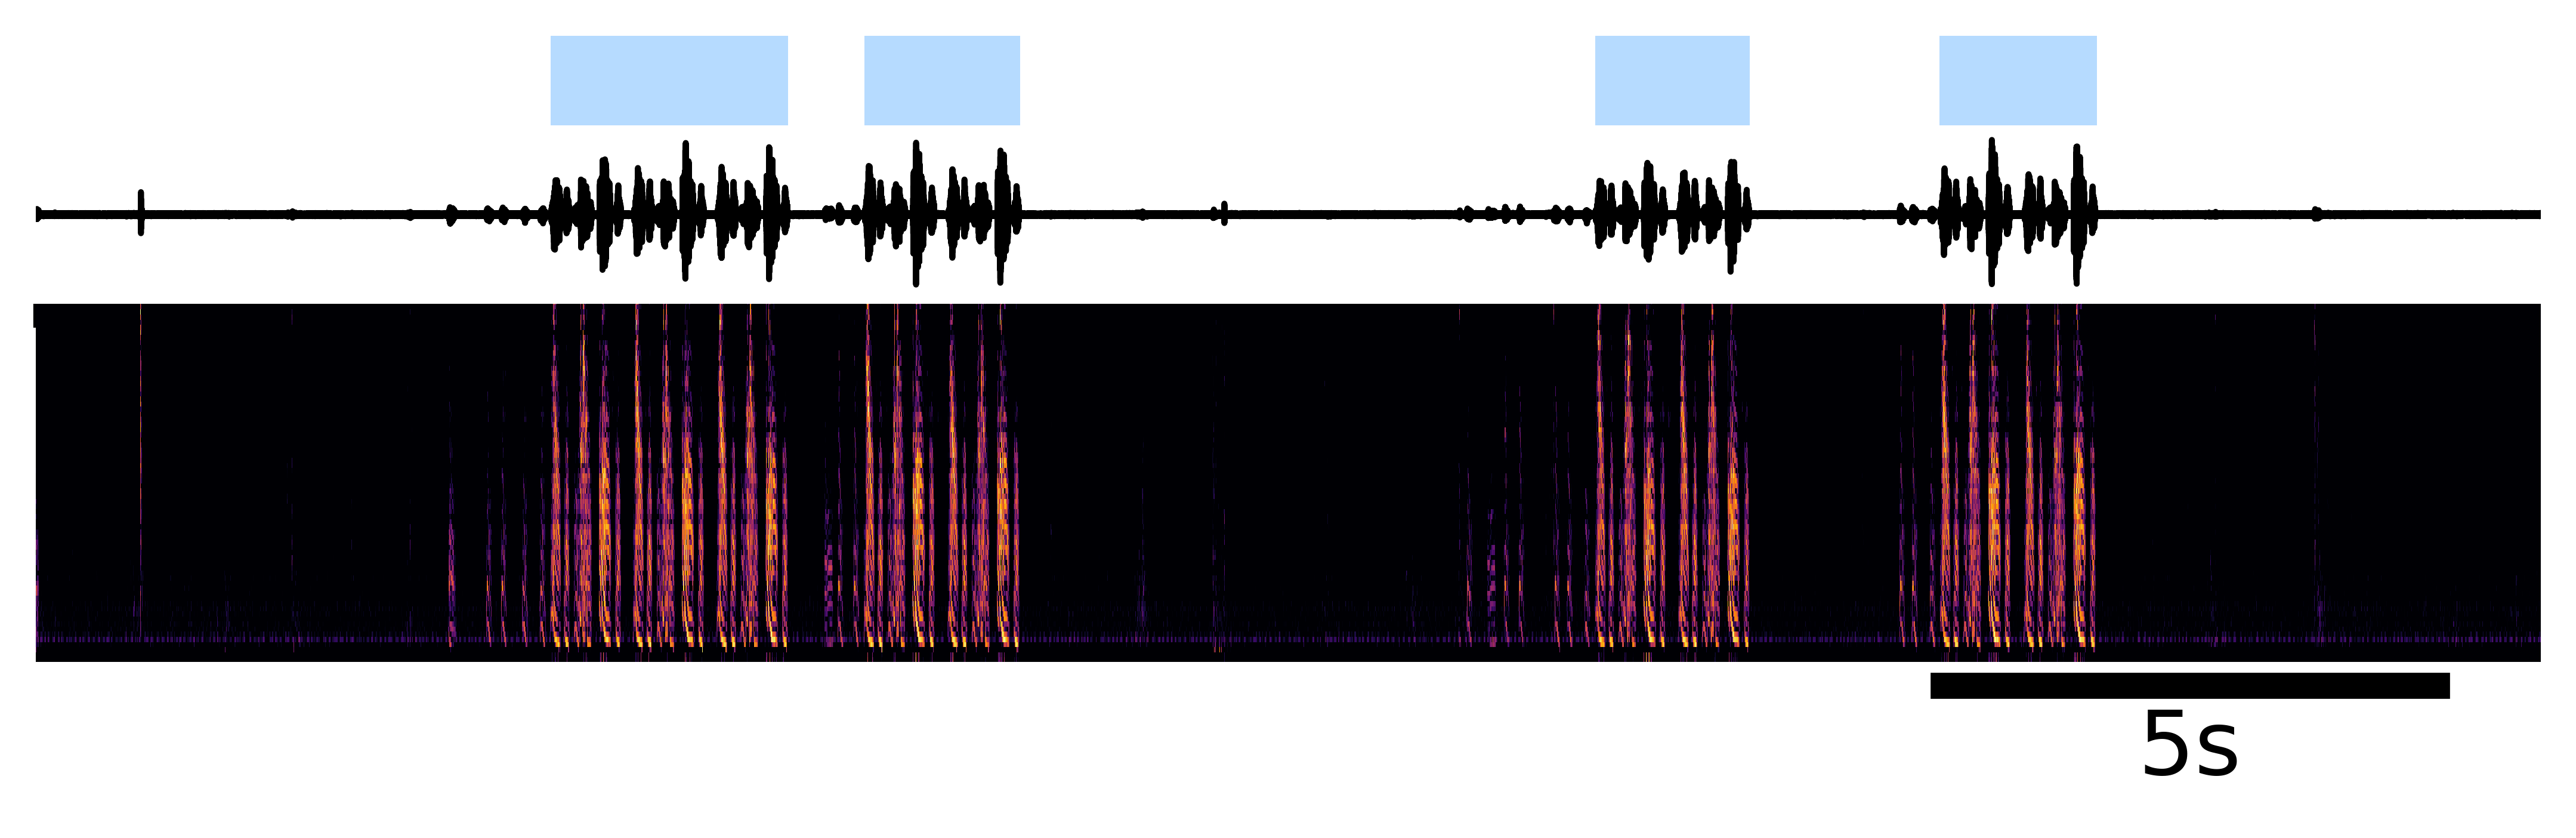

In [27]:
fig = plt.figure(figsize=(7.5,2.25), dpi = 300)

# Make the Subplots
# Color Labels
ax1 = fig.add_axes([0.0333, 0.86644, 0.933, 0.11111], frame_on=False, xticklabels=[], ylim=(0, 1))
# Pressure Waveform
ax2 = fig.add_axes([0.0333, 0.6444, 0.933, 0.22222], frame_on=False, xticklabels=[], ylim=(-1.2, 1.2))
# Spectrogram
ax3 = fig.add_axes([0.0333, 0.2, 0.933, 0.444444], ylim=(-1.2, 1.2))

# Handle plot alignment




# Plot the Behavioral Labels

for start, end in zip(first_syll[4], bout_ends[4]):
#     color = 'green'
    color = '#B6DBFF'

    corrected_start = (start-chunk_before_sample)/30000  # Correct for the Relative Start Time and resolution
    corrected_end = (end-chunk_before_sample)/30000 # Correct for the Relative Start Time and resolution
    ax1.axvspan(xmin=corrected_start, xmax=corrected_end, ymin=0,ymax=1, facecolor=color, alpha=1) # alpha=.5 for zoom effect
    ax1.set_xlim(0, chunk_level_xaxis[-1])

ax1.get_yaxis().set_visible(False)  # Hide the Y axis
ax1.get_xaxis().set_visible(False)  # Hide the Y axis

# Plot the Pressure Waveform
ax2.plot(chunk_level_xaxis, chunk_level_audio, color = 'black')
ax2.set_xlim(0, chunk_level_xaxis[-1])
ax2.get_yaxis().set_visible(False)  # Hide the Y axis

# Plot the Spectrogram
ax3 = sns.heatmap(s1, xticklabels=False, yticklabels= False, cbar = False, cmap= 'inferno')
ax3.invert_yaxis()
ax3.set_ylim((0,70))

# Add a Scale Bar
scalebar = AnchoredSizeBar(ax2.transData,
                           5, '5s', 'center right', 
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=.3,
                           fontproperties=fontprops, bbox_to_anchor=(.97, -.2),
                           bbox_transform=ax3.transAxes)

ax3.add_artist(scalebar)

# figure_name = 'Behavior_Explanitory_' + bird_id + '_' + session + '_Chunk_final_cb.png'
# figure_type_folder = FIGURES_DIR / 'Behavior_Explanation'

# # Check if Folder Path Exists
# if not figure_type_folder.exists():
#     figure_type_folder.mkdir(parents=True, exist_ok=True)

# figure_location = figure_type_folder / figure_name

# # fig.savefig(figure_location, format='svg')
# fig.savefig(figure_location, dpi=300, papertype=None, format='png')

fig.show()

------
# Make Bout Level Figure

In [28]:
# Determine the Bout Level Timing

bout_start_sample = first_syll[selected_chunk][0]
bout_end_sample = bout_ends[selected_chunk][0]

bout_before_adjustment = 1.1*30000
bout_after_adjustment = .3*30000

before_bout = bout_start_sample - int(bout_before_adjustment)
after_bout = bout_end_sample + int(bout_after_adjustment)

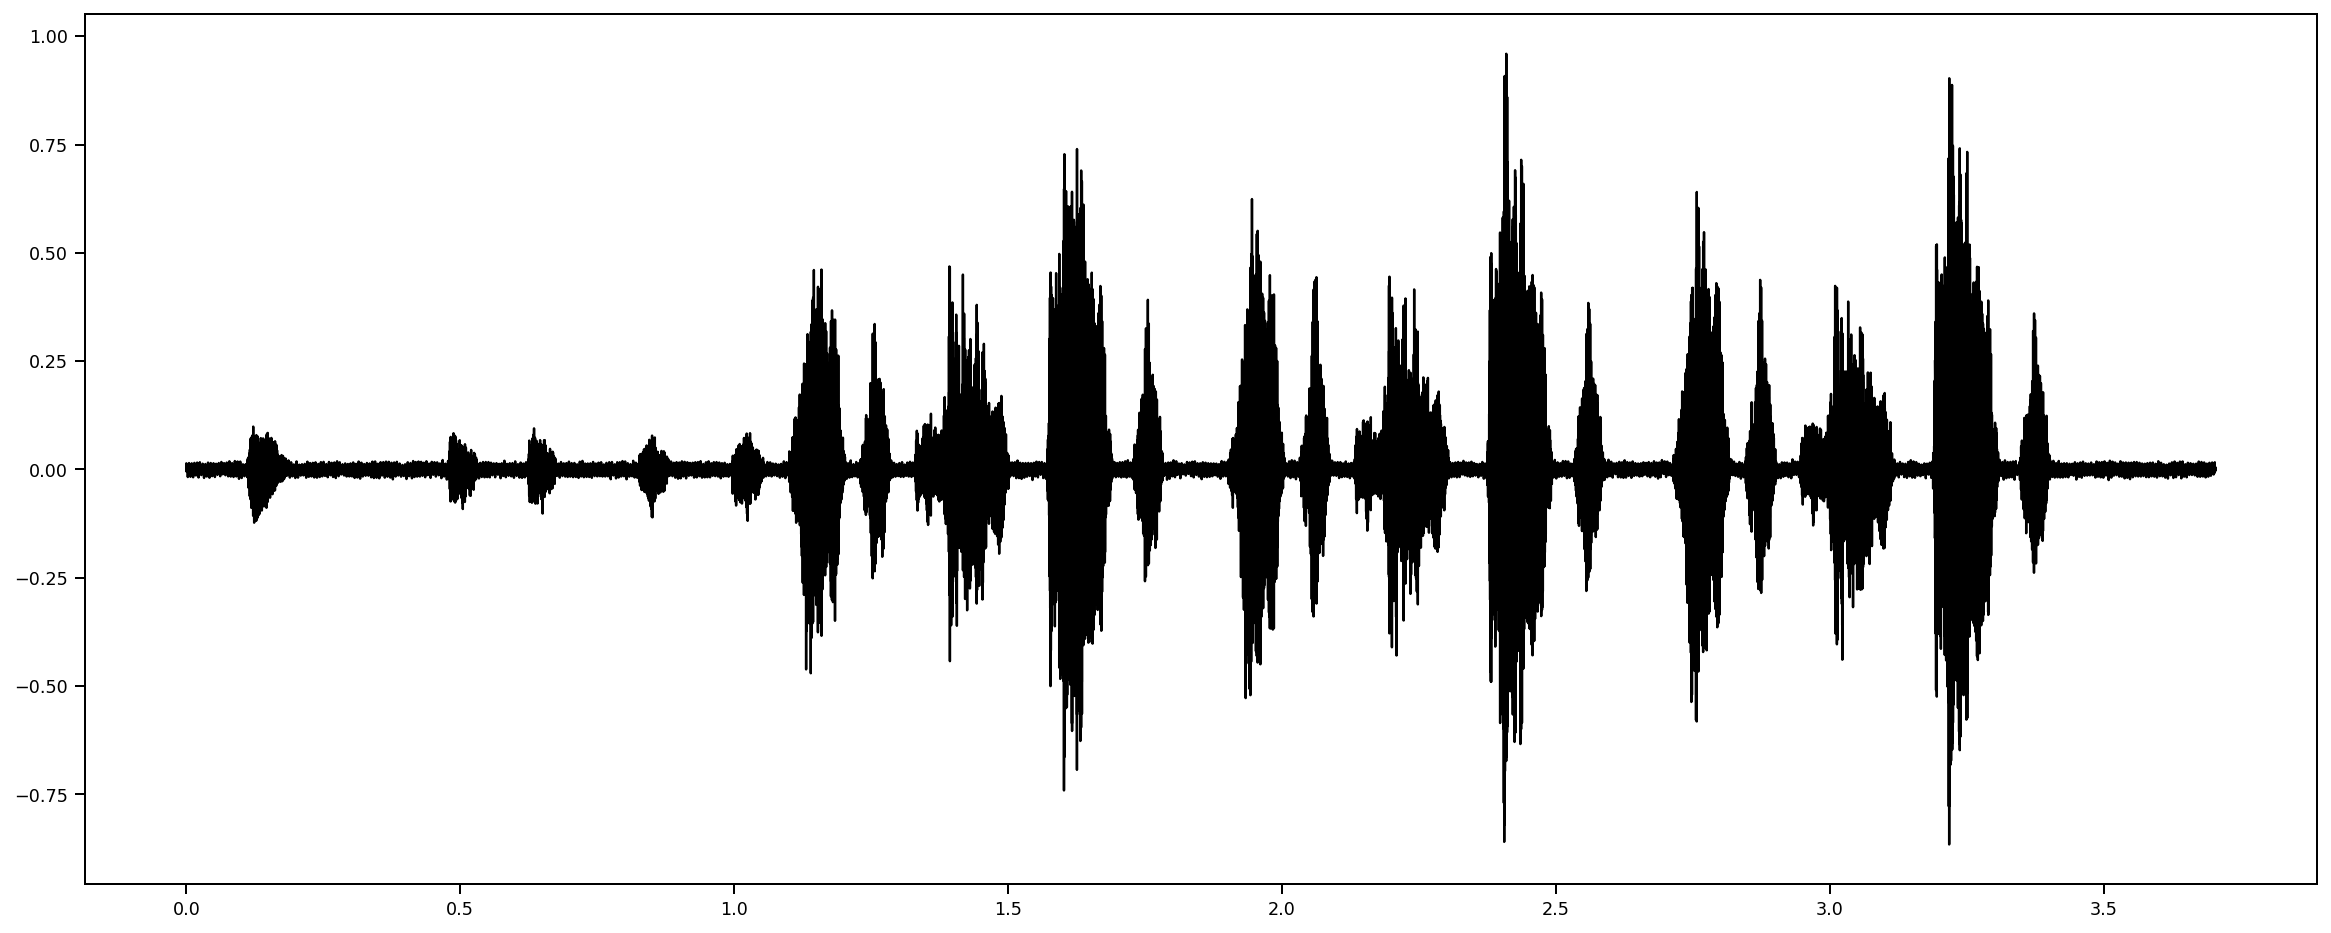

In [29]:
# Plot The Pressure Waveform
bout_level_audio = chunk1_audio[before_bout:after_bout]  # Clip out the Chunk level
bout_level_length = len(bout_level_audio)/30000  # Convert x to seconds
bout_level_xaxis = np.arange(0, bout_level_length, 1/30000)

plt.plot(bout_level_xaxis, bout_level_audio, color = 'black')
plt.show()

In [30]:
# Plot the Spectrogram 
bout_level_spect = chunk1_audio_spect[before_bout:after_bout]  # Get the Signal from time shown above

f2, t2, s2 = my_spectrogram(bout_level_spect, f_cut=.5, nfft=200)


In [31]:
def get_motif_end(contexts, labels):
    """ Get the Label or time of the end of the motif"""
    all_ends = []
    for context, chunk in zip(contexts, labels):
        chunk_ends = []
        for index, last_context in enumerate(context[:-1,0]):
            if last_context != 0 and context[index+1, 0] == 0:
#                 print(last_context)
#                 print(context[index+1, 2])
                chunk_ends.append(chunk[index])
        all_ends.append(chunk_ends)
    return all_ends

In [32]:
# Get the End of Every Motif

motif_ends = get_motif_end(test_context, chunk_onsets_list[1])

getting to the Y part
Done with the Y part


(0, 70)

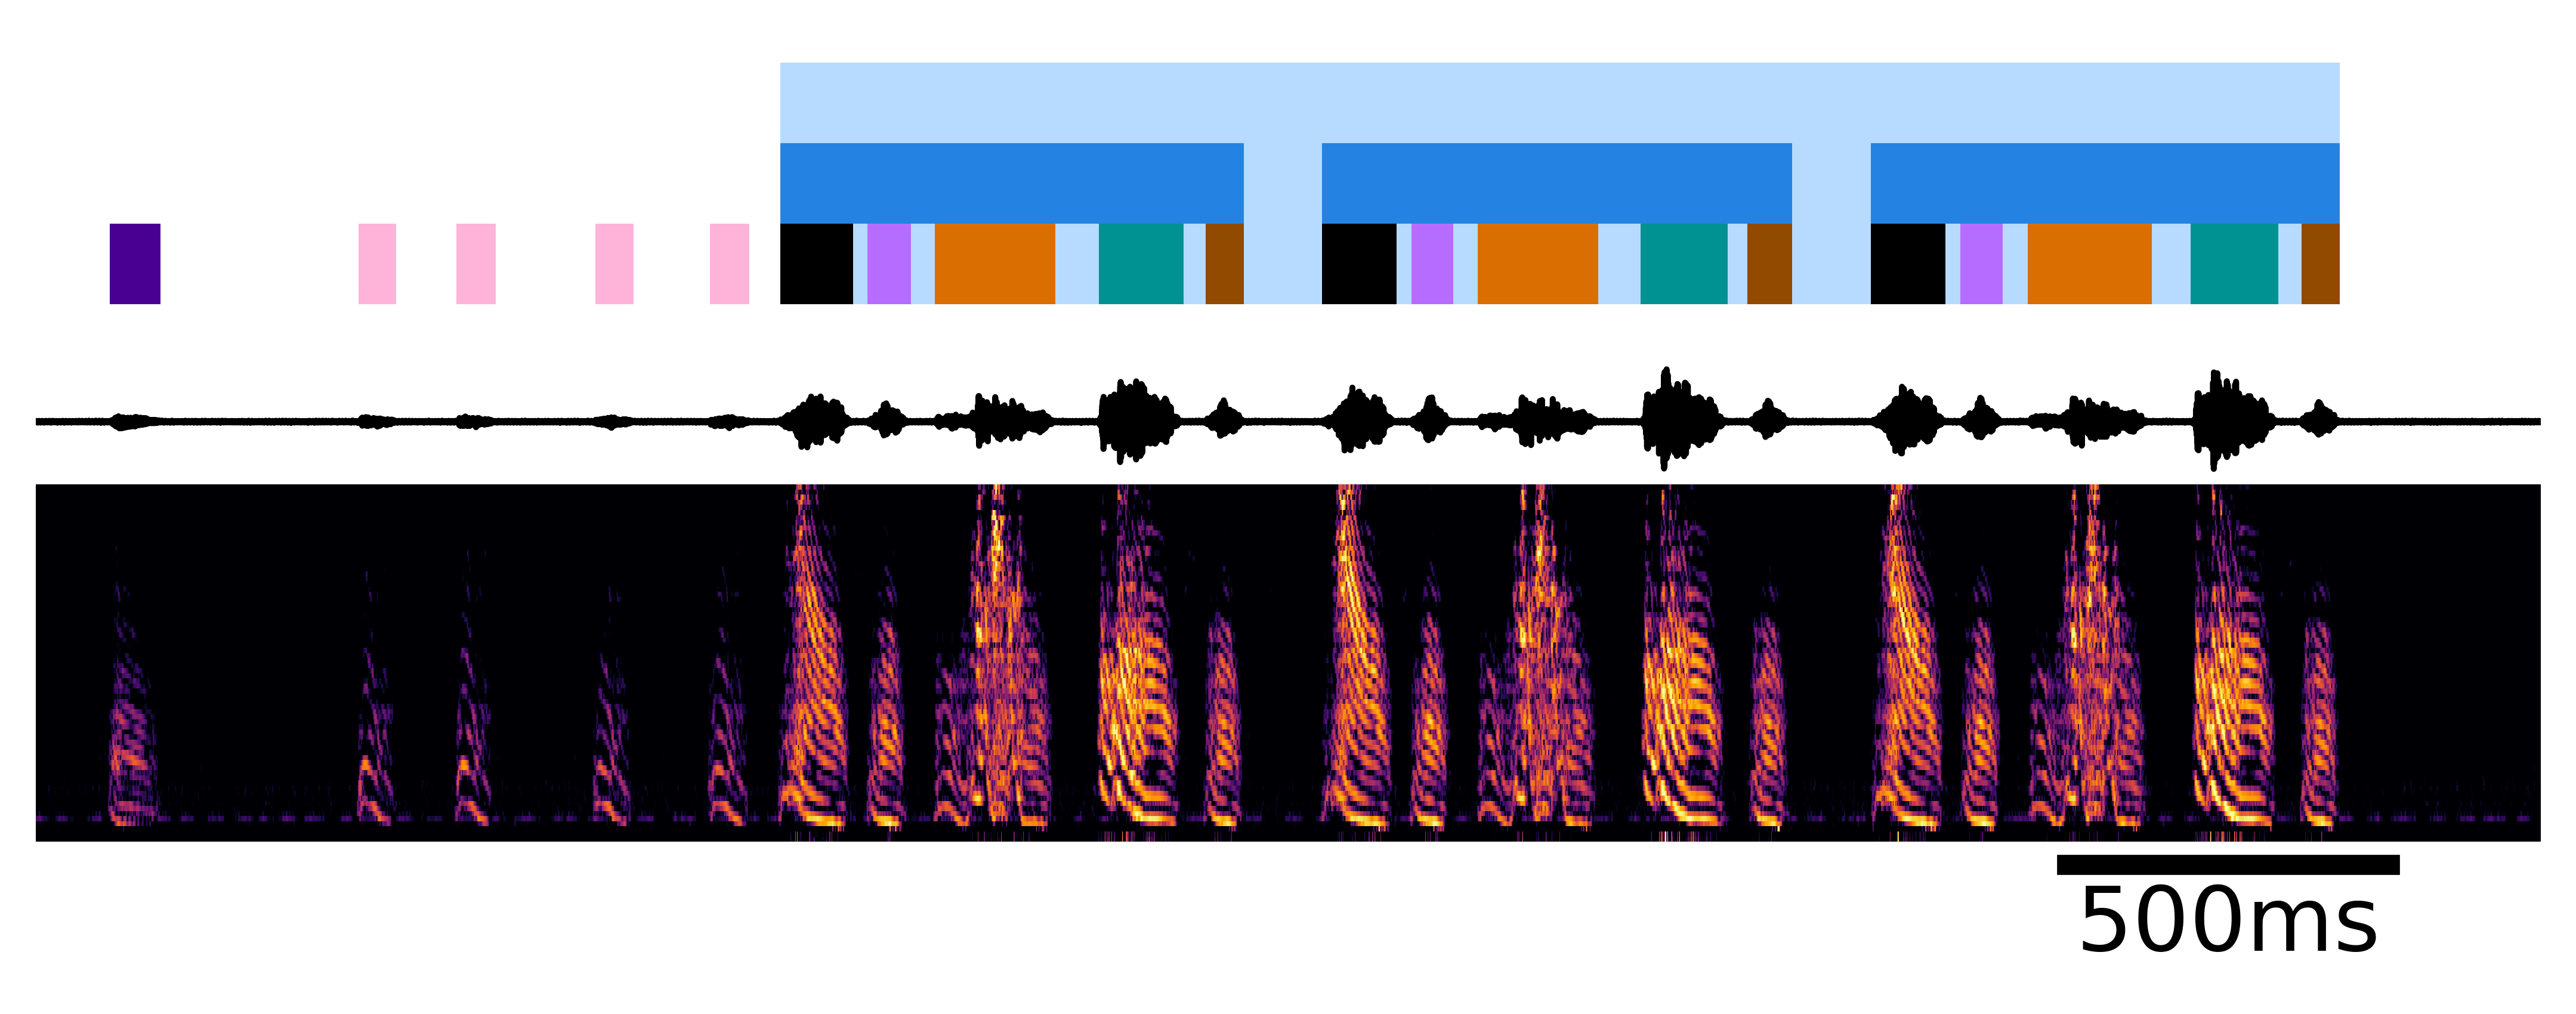

In [33]:
fig = plt.figure(figsize=(7.5,2.75), dpi = 300)


# Make the Subplots
# Color Labels
ax1 = fig.add_axes([0.0333, 0.6723, 0.933, 0.2727], frame_on=False, xticklabels=[], ylim=(0, 1))
# Pressure Waveform
ax2 = fig.add_axes([0.0333, 0.4863, 0.933, 0.133], frame_on=False, xticklabels=[], ylim=(-1.2, 1.2))
# Spectrogram
ax3 = fig.add_axes([0.0333, 0.1263, 0.933, 0.363], ylim=(-1.2, 1.2))

chunk_sel = 4

# Plot the Bout Level
bout_counter = 0
for start, end in zip(first_syll[chunk_sel], bout_ends[chunk_sel]):
#     bout_color = 'green'
    bout_color = '#B6DBFF'
    corrected_start = (start-before_bout)/30000  # Correct for the Relative Start Time and resolution
    corrected_end = (end-before_bout)/30000 # Correct for the Relative Start Time and resolution
    ax1.axvspan(xmin=corrected_start, xmax=corrected_end, ymin=.3,ymax=.9, facecolor=bout_color, alpha=1)
    
#     # Add Annotations for the different Levels
#     if corrected_start > 0 :
#         bout_counter += 1
#         middle_point2 = ((corrected_end - corrected_start)/2.75) + corrected_start
#         plt.annotate(f'Bout {bout_counter}', xy=(middle_point2, 1.11), xycoords='data', fontsize=20)
    
# Plot the Motif Level
motif_starts = times_of_interest[0][chunk_sel]
motif_counter = 0

for start, end in zip(motif_starts, motif_ends[chunk_sel]):
    motif_color = 'blue'
    motif_color = '#006DDB'
    corrected_start = (start-before_bout)/30000  # Correct for the Relative Start Time and resolution
    corrected_end = (end-before_bout)/30000 # Correct for the Relative Start Time and resolution
    ax1.axvspan(xmin=corrected_start, xmax=corrected_end, ymin=.3,ymax=.6, facecolor=motif_color, alpha=0.8)

#     # Add Annotations for the different Levels
#     if corrected_start > 0 :
#         motif_counter += 1
#         middle_point2 = ((corrected_end - corrected_start)/5) + corrected_start
#         plt.annotate(f'Motif {motif_counter}', xy=(middle_point2, 1.0), xycoords='data', fontsize=20)
        
# ['black', 'red', 'orange', 'yellow', 'saddlebrown', 'blue', 'green', 'white', 'pink', 'purple'])

# Plot the Syllable Level
# colors= {1:'black',2:'red',3:'orange', 4:'yellow' ,5:'saddlebrown', 6:'blue', 7:'green', 8:'white','I':'pink', 'C':'purple', 'BUFFER': 'white'}
colors= {1:'#000000',2:'#B66DFF',3:'#db6e00', 4:'#009292' ,5:'#924900', 6:'#006DDB', 7:'#B6DBFF',
         8:'white','I':'#feb4d9', 'C':'#490092', 'BUFFER': 'white'}

# 1: #000000
# 2: #004949
# 3: #009292
# 4: #FF6DB6
# 5: #feb4d9  #rgb(254, 180, 217) ##FFB677
# 6: #490092
# 7: #006DDB
# 8: #B66DFF
# 9: #6DB6FF
# 10: #B6DBFF
# 11: #920000
# 12: #924900
# 13: #db6e00  #rgb(219, 110, 0)
# 14: #24FF24
# 15: #FFFF6D
# # green> #B6DBFF

for label, start, end in zip(chunk_labels, chunk_starts, chunk_ends):
    color = colors[label]
    corrected_start = (start-before_bout)/30000  # Correct for the Relative Start Time and resolution
    corrected_end = (end-before_bout)/30000 # Correct for the Relative Start Time and resolution
    if corrected_start > -.1 and corrected_end< 3.9:
        ax1.axvspan(xmin=corrected_start, xmax=corrected_end, ymin=0,ymax=.3, facecolor=color, alpha=1)
    
#     # Add Annotations for the different Levels
#     if corrected_start > 0 :
#         if label in [1,2,3,4,5,6,'I']:
#             middle_point2 = ((corrected_end - corrected_start)/6) + corrected_start
#             plt.annotate(str(label), xy=(middle_point2, .9), xycoords='data', fontsize=20)

ax1.set_xlim(0,3.7)
ax1.get_yaxis().set_visible(False)  # Hide the Y axis
ax1.get_xaxis().set_visible(False)  # Hide the Y axis


# Audio Pressure Waveform
timeseries_audio = chunk1_audio[before_bout:after_bout]
timeseries_length = len(timeseries_audio)/30000  # Convert x to seconds
ax2.plot(np.arange(0, timeseries_length, 1/30000), timeseries_audio, color = "black")
ax2.get_yaxis().set_visible(False)  # Hide the Y axis
ax2.get_xaxis().set_visible(False)  # Hide the Y axis
ax2.set_xlim(0,3.7)

# Plot the Spectrogram
ax3 = sns.heatmap(s2, xticklabels=False, yticklabels= False, cbar = False, cmap= 'inferno')
ax3.invert_yaxis()


print("getting to the Y part")
# Edit the Y-Axis
for ind, label in enumerate(ax2.get_yticklabels()):
    if ind == 70:
        label.set_visible(True)
    elif ind == 0:
        label.set_visible(True)
    else:
        label.set_visible(False) 
        
print("Done with the Y part")

# Add a Scale Bar
scalebar = AnchoredSizeBar(ax2.transData,
                           .5, '500ms', 'center right', 
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=.3,
                           fontproperties=fontprops, bbox_to_anchor=(.95, -.2),
                           bbox_transform=ax3.transAxes)

ax2.add_artist(scalebar)

ax3.set_ylim((0,70))


# figure_name = 'Behavior_Explanitory_' + bird_id + '_' + session + '_bout_final_cb.png'
# figure_type_folder = FIGURES_DIR / 'Behavior_Explanation'

# # Check if Folder Path Exists
# if not figure_type_folder.exists():
#     figure_type_folder.mkdir(parents=True, exist_ok=True)

# figure_location = figure_type_folder / figure_name

# # fig.savefig(figure_location, format='png')
# fig.savefig(figure_location, dpi=300, papertype=None, format='png')

            

# Make A Large Raster for the Full Recording

In [34]:
days_report = _load_json_data(data_name='Report', bird_id=bird_id, session=session)  # Get the Report for this bird


In [35]:
days_report

{'duration': 250372200, 'num_motifs': 19, 'num_repeats': 0}

In [36]:
hour_1_dur = 60*60

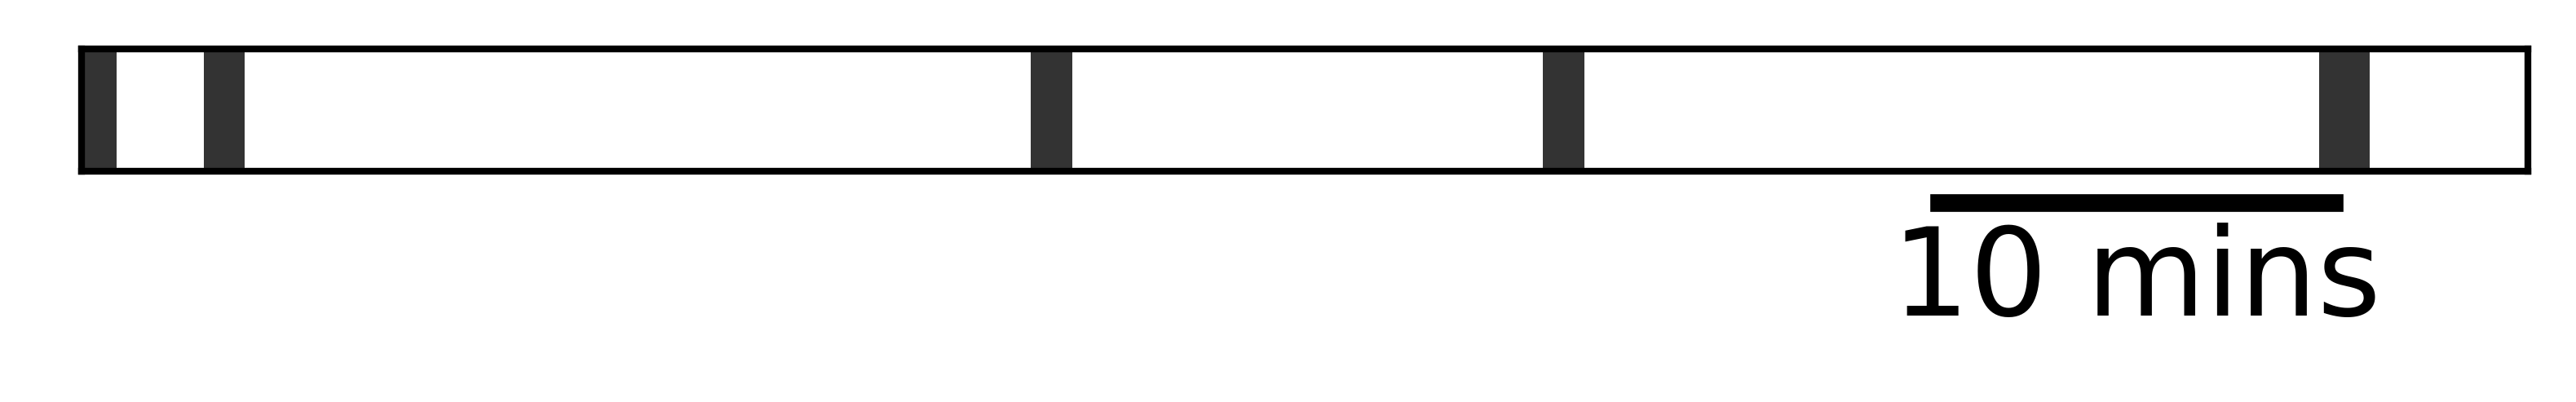

In [37]:
fig = plt.figure(figsize=(5.5,.75), dpi = 300)



# Make the Subplots
# Color Labels
# [left, bottom, width, height]
ax1 = fig.add_axes([0.045, 0.5333, 0.909, 0.3333])
for start, end in zdata.song_index:
    bout_color = 'black'
    corrected_start = (start/30000)  # Correct for the Relative Start Time and resolution
    corrected_end = (end/30000) # Correct for the Relative Start Time and resolution
    ax1.axvspan(xmin=corrected_start, xmax=corrected_end, ymin=0,ymax=1, facecolor=bout_color, alpha=0.8)

ax1.set_xlim((0, hour_1_dur))
ax1.set_ylim((0,1))
ax1.get_yaxis().set_visible(False)  # Hide the Y axis
ax1.get_xaxis().set_visible(False)  # Hide the Y axis

# Add a Scale Bar
scalebar = AnchoredSizeBar(ax1.transData,
                           60*10, '10 mins', 'center right', 
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=.1,
                           fontproperties=fontprops, bbox_to_anchor=(.95, -.8),
                           bbox_transform=ax1.transAxes)

ax1.add_artist(scalebar)

# figure_name = 'Behavior_Explanitory_' + bird_id + '_' + session + '_full_recording_final.png'
# figure_type_folder = FIGURES_DIR / 'Behavior_Explanation'

# # Check if Folder Path Exists
# if not figure_type_folder.exists():
#     figure_type_folder.mkdir(parents=True, exist_ok=True)

# figure_location = figure_type_folder / figure_name

# # fig.savefig(figure_location, format='png')
# fig.savefig(figure_location, dpi=300, papertype=None, format='png')


plt.show()